# Load packages 

In [3]:
import tensorflow as tf
from tensorflow import keras
import openpyxl
from keras import layers
import pyarrow as pa
import pyarrow.parquet as pq
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers,models,callbacks
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.optimizers import Adam
import numpy as np
import shutil
import glob
import pandas as pd
import dask
import dask.dataframe as dd
import dask.array as da
import dask.bag as db
import requests
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, Normalizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
from sklearn.metrics import confusion_matrix
from sklearn.manifold import TSNE
from umap import UMAP
from scipy.stats import ttest_ind
from scipy.stats import f_oneway
import os
import time
from io import StringIO
from joblib import Parallel, delayed
from sklearn.metrics import ( accuracy_score, balanced_accuracy_score, roc_auc_score, roc_curve)
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    accuracy_score,
    balanced_accuracy_score,
    roc_auc_score,
    roc_curve,
    mean_squared_error,
    r2_score
)


print(os.getcwd())
print(keras.__version__)
print(pd.__version__)
print(dask.__version__)

#Ensure reproductibility
seed=42

/Users/safaakassioui/Documents/IA_DL/projet
3.11.3
2.3.2
2024.8.2


# Load the dataset 

In [4]:
expr_IDC_ILC = pd.read_csv("TCGA_IDC_ILC.tsv", sep='\t', index_col=0)
clinical = pd.read_csv("clinical_metadata.csv", index_col="Case_ID")

# Creat a sub dataset with lumA patients

In [ ]:
idx = clinical.index.intersection(expr_IDC_ILC.index)

mask = (clinical.loc[idx, "PAM50"] == "LumA") & (clinical.loc[idx, "Final Pathology"].isin(["IDC","ILC"]))
idx_luma = idx[mask]

X_luma = expr_IDC_ILC.loc[idx_luma]
y_luma = clinical.loc[idx_luma, "Final Pathology"]  

In [110]:
y_luma.value_counts()

Final Pathology
IDC    199
ILC    106
Name: count, dtype: int64

# import of the function autoencoder 

In [6]:
def autoencoder2(
    X_scaled: pd.DataFrame,
    clinical: pd.DataFrame | None = None,
    color_by: str | None = None,
    latent_dim: int = 30,
    test_size: float = 0.2,
    seed: int = 42,
    epochs: int = 100,
    batch_size: int = 32
): 
    # 1. Conversion DataFrame → numpy
    X = X_scaled.values.astype("float32")

    # 2. Train / validation split
    X_train, X_val = train_test_split(
        X, test_size=test_size, random_state=seed
    )

    # 3. Modèle
    input_dim = X_train.shape[1]

    # -------- Encoder --------
    inputs = layers.Input(shape=(input_dim,))
    z = layers.Dense(512, activation='relu')(inputs)
    z = layers.Dense(128, activation='relu')(z)
    latent = layers.Dense(latent_dim, activation='linear', name='latent')(z)

    encoder = models.Model(inputs, latent, name='encoder')

    # -------- Decoder --------
    z = layers.Dense(128, activation='relu')(latent)
    z = layers.Dense(512, activation='relu')(z)
    outputs = layers.Dense(input_dim, activation='linear')(z)

    # -------- Autoencoder --------
    ae = models.Model(inputs, outputs, name='ae')

    ae.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss='mse'
    )

    ae.summary()

    # 4. Entraînement (callbacks)
    cb = [
        EarlyStopping(
            monitor="val_loss",
            patience=8,
            restore_best_weights=True
        ),
        ReduceLROnPlateau(
            monitor="val_loss",
            factor=0.5,
            patience=4,
            min_lr=1e-6
        )
    ]

    history = ae.fit(
        X_train, X_train,
        validation_data=(X_val, X_val),
        epochs=200,
        batch_size=batch_size,
        callbacks=cb,
        verbose=1
    )

    # 5. Courbe de loss
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('MSE')
    plt.title('Autoencoder training')
    plt.legend()
    plt.show()

    # 6. Encoder tout le dataset
    Z = encoder.predict(X, verbose=0)
    Z = pd.DataFrame(
        Z,
        index=X_scaled.index,
        columns=[f"z{i+1}" for i in range(latent_dim)]
    )

    return encoder, ae, Z

Model: "ae"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 2000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 512)            │     1,024,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent (Dense)                  │ (None, 30)             │         3,870 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 128)            │         3,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 2000)           │     1,026,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,190,062 (8.35 MB)

 Trainable params: 2,190,062 (8.35 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 1.0409 - val_loss: 0.8826 - learning_rate: 1.0000e-04
Epoch 2/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.9547 - val_loss: 0.8606 - learning_rate: 1.0000e-04
Epoch 3/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.9150 - val_loss: 0.8372 - learning_rate: 1.0000e-04
Epoch 4/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.8797 - val_loss: 0.8129 - learning_rate: 1.0000e-04
Epoch 5/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.8435 - val_loss: 0.7879 - learning_rate: 1.0000e-04
Epoch 6/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.8069 - val_loss: 0.7605 - learning_rate: 1.0000e-04
Epoch 7/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.7675 - val_loss: 0.7349 - learning_rate: 1.0000e-04
Epoch 8/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.7314 - val_loss: 0.7123 - learning_rate: 1.0000e-04
Epoch 9/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.6960 - val_loss: 0.6917 - learning_rate: 1.0

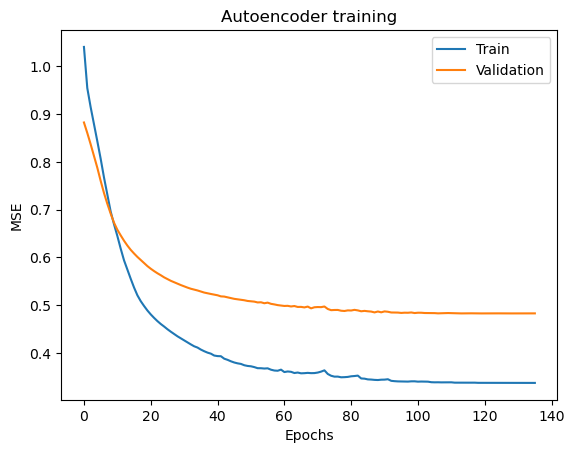

In [7]:
encoder, ae, Z = autoencoder2(
    X_scaled=X_luma
)

/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


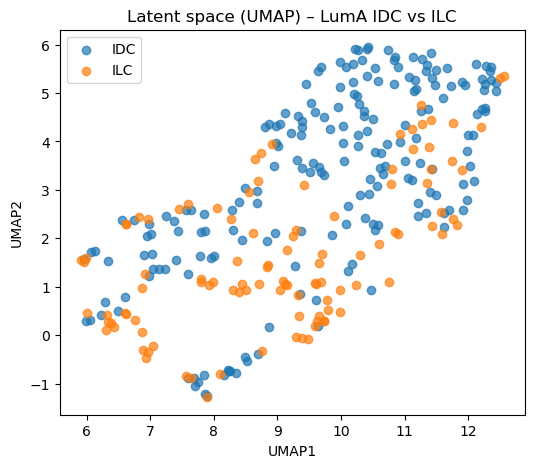

In [8]:
from umap import UMAP

umap2 = UMAP(n_components=2, random_state=42)
Z_umap = umap2.fit_transform(Z.values)

plt.figure(figsize=(6,5))
for lab in ["IDC", "ILC"]:
    mask = clinical.loc[Z.index, "Final Pathology"] == lab
    plt.scatter(Z_umap[mask,0], Z_umap[mask,1], label=lab, alpha=0.7)

plt.legend()
plt.title("Latent space (UMAP) – LumA IDC vs ILC")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.show()

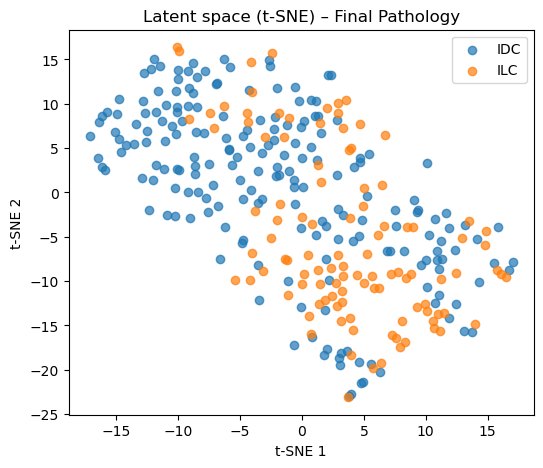

In [42]:
labels = clinical.loc[Z.index, "Final Pathology"]

tsne = TSNE(
    n_components=2,
    perplexity=30,      # bon point de départ pour ~700 patients
    learning_rate="auto",
    init="pca",
    random_state=42
)

Z_tsne = tsne.fit_transform(Z.values)

plt.figure(figsize=(6,5))
for lab in labels.unique():
    mask = labels == lab
    plt.scatter(
        Z_tsne[mask, 0],
        Z_tsne[mask, 1],
        label=lab,
        alpha=0.7
    )

plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.title("Latent space (t-SNE) – Final Pathology")
plt.legend()
plt.show()

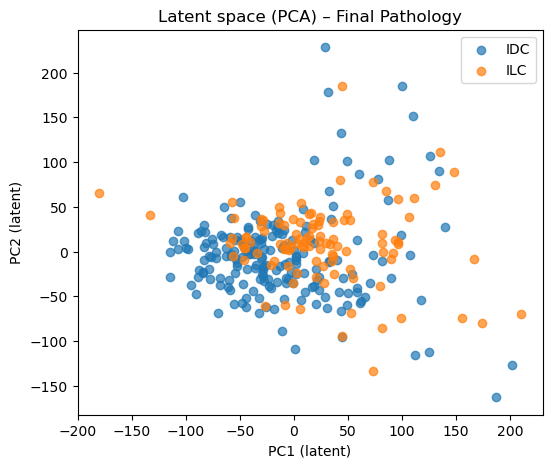

In [43]:
labels = clinical.loc[Z.index, "Final Pathology"]
Z_pca = PCA(n_components=2, random_state=42).fit_transform(Z.values)

plt.figure(figsize=(6,5))
for lab in labels.unique():
    mask = labels == lab
    plt.scatter(
        Z_pca[mask, 0],
        Z_pca[mask, 1],
        label=lab,
        alpha=0.7
    )

plt.xlabel("PC1 (latent)")
plt.ylabel("PC2 (latent)")
plt.title("Latent space (PCA) – Final Pathology")
plt.legend()
plt.show()

# autres 

In [10]:
# Z_luma : latent dataframe indexé par samples (mêmes index que X_luma)

from scipy.stats import spearmanr

cors = []
for zi in Z.columns:
    r = X_luma.apply(lambda g: spearmanr(g.values, Z[zi].values, nan_policy="omit").correlation)
    cors.append(r)

cors = pd.concat(cors, axis=1)
cors.columns = Z.columns  # rows=genes, cols=z dims

# ex: gènes les plus associés à z1
cors["z1"].sort_values(ascending=False).head(30)

EIF3I       0.702699
SNRPD2      0.689125
RPL8        0.673779
PPIA        0.664014
PARK7       0.650585
ATP6V0B     0.642898
RPS24       0.634463
ATP5MC2     0.632527
RPL18       0.631184
CCT7        0.625234
RPS21       0.620843
RPL38       0.619469
NDUFB9      0.618680
RPS2        0.617972
SLC25A39    0.617629
PRDX5       0.613675
SSR4        0.606120
EDF1        0.603602
UQCRB       0.602919
NDUFS5      0.601990
RPL28       0.601024
CHCHD2      0.599601
TXN         0.598861
RPL35       0.596025
VPS28       0.595920
ERGIC3      0.593926
CYC1        0.593073
BCAP31      0.590975
RPL36       0.587374
CFL1        0.585922
Name: z1, dtype: float64

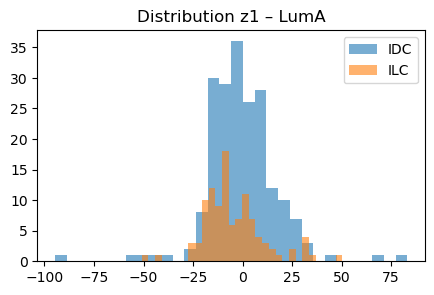

In [11]:
plt.figure(figsize=(5,3))
plt.hist(Z.loc[y_luma=="IDC","z1"], alpha=0.6, label="IDC", bins=30)
plt.hist(Z.loc[y_luma=="ILC","z1"], alpha=0.6, label="ILC", bins=30)
plt.legend(); plt.title("Distribution z1 – LumA"); plt.show()

In [15]:
from scipy.stats import mannwhitneyu
mannwhitneyu(
    Z.loc[y_luma=="IDC","z1"],
    Z.loc[y_luma=="ILC","z1"],
    alternative="two-sided"
)

MannwhitneyuResult(statistic=12728.0, pvalue=0.0029482802667541307)

In [13]:
cors["z2"].sort_values(ascending=False).head(30)

FAU        0.645952
RPS9       0.633777
NOP53      0.620544
RPL13      0.620277
RPLP2      0.611943
RPL35      0.609448
RPL18      0.599221
RPS28      0.591607
RPS21      0.582349
RPL34      0.576465
RPL18A     0.575710
COX4I1     0.575055
RPS16      0.574962
RPS19      0.573742
RPS11      0.570302
EIF3K      0.569566
RPL13A     0.566407
FKBP8      0.562443
RPS15      0.558165
UBA52      0.554935
RPS7       0.547462
RPL11      0.543583
RPL37A     0.540498
SLC25A6    0.539661
RPL36      0.533264
RPS14      0.531754
RPL32      0.527821
RPS8       0.525666
TNNC2      0.525289
RPS25      0.524308
Name: z2, dtype: float64

In [14]:
cors["z3"].sort_values(ascending=False).head(30)

GBP4       0.445873
PTPRC      0.423167
PARP14     0.411734
MALAT1     0.382307
PIK3CA     0.370988
IFI44L     0.370629
IFI16      0.357661
VCAM1      0.356867
MED13      0.355174
MRC1       0.353217
CD47       0.350460
SPAG9      0.346680
RNF213     0.345649
DDX5       0.344829
GBP1       0.342699
TMEM64     0.341248
TTN        0.340008
SMG1       0.338206
KCTD12     0.336264
PRKAR1A    0.333001
PTPN1      0.331927
NEB        0.325448
IL2RB      0.325055
HNRNPH1    0.324692
CD163      0.324314
IFIT1      0.321391
APOL6      0.318916
SELL       0.318902
IFIT3      0.318592
STAT1      0.316309
Name: z3, dtype: float64

In [16]:
cors["z4"].sort_values(ascending=False).head(30)

GSN         0.737066
FBLN5       0.712782
AQP1        0.709272
NOP53       0.705034
DEPP1       0.691769
CAVIN1      0.687179
MFAP4       0.677820
CRYAB       0.662142
RPL11       0.660923
SERPING1    0.659458
TNNT3       0.657426
VIM         0.657340
C1R         0.655768
RPLP2       0.651282
ZYX         0.650347
ZFP36       0.648875
CCN1        0.648179
JUN         0.647179
CAV1        0.644922
CDC42EP1    0.643480
RPL13       0.637707
MYL9        0.636214
CX3CL1      0.627696
ANXA1       0.623247
SAA1        0.614797
RPL34       0.613921
PYGM        0.611284
RPS6        0.610105
PPP1R1A     0.605074
PRELP       0.604479
Name: z4, dtype: float64

In [17]:
cors["z5"].sort_values(ascending=False).head(30)

RPL8        0.703506
EIF3I       0.673463
SLC25A39    0.657240
RPS2        0.655462
ATP5MC2     0.654290
SNRPD2      0.653697
PARK7       0.652946
VPS28       0.642106
PPIA        0.615843
CYC1        0.615795
PRDX5       0.615100
PPP2R1A     0.610840
ERGIC3      0.607759
ELOB        0.604951
EDF1        0.600453
TUFM        0.599658
UQCRC1      0.599649
TRIM28      0.597977
BOP1        0.595712
NDUFB9      0.595167
CFL1        0.591552
RPL28       0.590202
PUF60       0.587667
RPL18       0.586545
CCT7        0.584332
SERINC2     0.579521
CHCHD2      0.578664
FAM83H      0.577818
DCXR        0.577750
MLF2        0.577618
Name: z5, dtype: float64

# NN test 

In [20]:
def mlp(
    X: pd.DataFrame,
    y: pd.Series,
    task : str = 'classification',
    test_size: float = 0.2,
    seed: int = 42,
    hidden_layers: list = [128, 64],
    dropout: float = 0.3, # regularisation du model-on eteint certains neurones afin que le model soit plus robuste
    lr: float = 1e-3, # learning rate : La taille du pas que fait l’optimiseur (Adam) pour mettre à jour les poids du réseau.
    epochs: int = 200,
    batch_size: int = 32, 
    class_weight: dict | None = None,   
    verbose: int = 1
):
    

    # 1. data prep

    # on convertit le dataframe en array numpy 
    X_np = X.values.astype('float32')

    # choix de la metadonnées a predire 
    if task == 'classification': 
        if y.dtype == "object":
            LE = LabelEncoder()
            y_enc = LE.fit_transform(y.values)
            class_names = LE.classes_
        else :
            y_enc = y.values.astype(int)
            class_names = np.unique(y_enc)

        n_classes = len(np.unique(y_enc))

    elif task=='regression':
        y_enc = y.values.astype('float32')
        class_names = None 
        n_classes = 1  


    # 2. Train - validation split 

    X_train, X_val, y_train, y_val = train_test_split(X_np, y_enc, test_size=test_size, random_state=seed, stratify= y_enc if task == 'classification' else None) 

    print("Étape 2 OK")
    print("X_train:", X_train.shape)
    print("X_val:", X_val.shape)
    print("y_train distribution:", np.bincount(y_train) if task=="classification" else "regression")    


    # 3. Build Model

    input_dim = X_train.shape[1] 

    #couche d'entree 
    inputs= layers.Input(shape=(input_dim,))

    z = inputs

    for units in hidden_layers : 
        z = layers.Dense(units, activation='relu')(z)
        if dropout>0:
            z = layers.Dropout(dropout)(z)

    
    #couche de sortie selon la task 
    if task == 'classification':
        if n_classes == 2:
            outputs = layers.Dense(1, activation="sigmoid")(z)
            loss = "binary_crossentropy"
        else :
            outputs = layers.Dense(n_classes, activation='softmax')(z)
            loss = "sparse_categorical_crossentropy"

    elif task== 'regression': 
        outputs = layers.Dense(1, activation='linear')(z)
        loss = 'mse'

    model = models.Model(inputs, outputs, name = 'mlp')

    model.compile(optimizer=Adam(learning_rate=lr), loss=loss, metrics=['accuracy'] if task=='classification' else ['mse'])

    model.summary()



    # 4. train the model 

     # callabck : earlystopping donc si le model ne s'ameliore plus on arrete, reduceonplateau : si le model stagne on fait des pas plus petit 
    callbacks = [EarlyStopping (monitor= 'val_loss', patience = 10, restore_best_weights = True), ReduceLROnPlateau( monitor='val_loss', factor=0.5, patience=5, min_lr = 1e-6)]

    history = model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs=epochs, batch_size=batch_size, callbacks=callbacks, verbose=verbose)

    # 5. Evaluation 

    # prediction sur la validation 
    y_pred = model.predict(X_val, verbose = 0)

    if task == 'classification' : 
        if n_classes == 2 :
            y_pred_label = (y_pred >= 0.5).astype(int).ravel()
        else:
             y_pred_label = y_pred.argmax(axis=1)

        # Métriques principales
        acc = accuracy_score(y_val, y_pred_label)
        bacc = balanced_accuracy_score(y_val, y_pred_label)

        print("Accuracy:", acc)
        print("Balanced accuracy:", bacc)
        print("\nClassification report:")
        print(classification_report(y_val, y_pred_label, target_names=class_names))

        # 3) Confusion matrix
        cm = confusion_matrix(y_val, y_pred_label)
        print("Confusion matrix:\n", cm)

        disp = ConfusionMatrixDisplay( confusion_matrix=cm, display_labels=class_names )

        disp.plot(cmap="Blues", values_format="d")
        plt.title("Confusion Matrix – IDC vs ILC")
        plt.show()

    # Cas régression
    elif task == "regression":

        mse = mean_squared_error(y_val, y_pred)
        r2 = r2_score(y_val, y_pred)

        print("MSE:", mse)
        print("R²:", r2)


    # 6. visualisation 


    # learning curves 
    plt.figure(figsize=(6,4))
    plt.plot(history.history["loss"], label="Train loss")
    plt.plot(history.history["val_loss"], label="Validation loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training curves")
    plt.legend()
    plt.show()


    # ROC curve 
    if task == "classification" and n_classes == 2:

        y_prob = y_pred.ravel()
        auc = roc_auc_score(y_val, y_prob)

        fpr, tpr, _ = roc_curve(y_val, y_prob)

        plt.figure(figsize=(5,4))
        plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
        plt.plot([0,1], [0,1], "k--")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC curve")
        plt.legend()
        plt.show()

    return model, history
    


Étape 2 OK
X_train: (244, 30)
X_val: (61, 30)
y_train distribution: [159  85]


Model: "mlp"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_22 (InputLayer)     │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_59 (Dense)                │ (None, 32)             │           992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,025 (4.00 KB)

 Trainable params: 1,025 (4.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.4016 - loss: 9.8349 - val_accuracy: 0.5410 - val_loss: 5.9621 - learning_rate: 1.0000e-04
Epoch 2/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4549 - loss: 8.7031 - val_accuracy: 0.5410 - val_loss: 5.7057 - learning_rate: 1.0000e-04
Epoch 3/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4508 - loss: 9.1226 - val_accuracy: 0.5246 - val_loss: 5.4584 - learning_rate: 1.0000e-04
Epoch 4/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4344 - loss: 8.3465 - val_accuracy: 0.5246 - val_loss: 5.2468 - learning_rate: 1.0000e-04
Epoch 5/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4508 - loss: 7.2205 - val_accuracy: 0.5246 - val_loss: 5.0272 - learning_rate: 1.0000e-04
Epoch 6/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4672 - loss: 7.2622 - val_accuracy: 0.5082 - val_loss: 4.8131 - learning_rate: 1.0000e-04
Epoch 7/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4590 - loss:

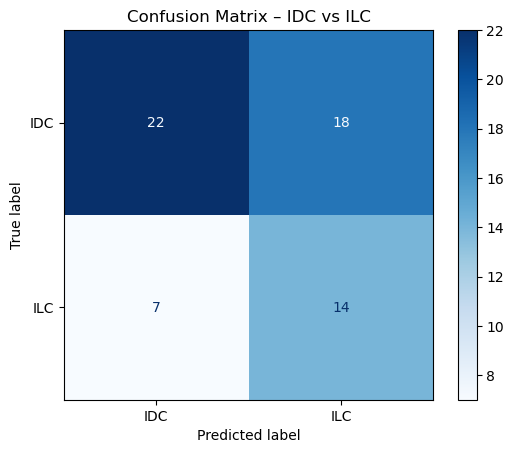

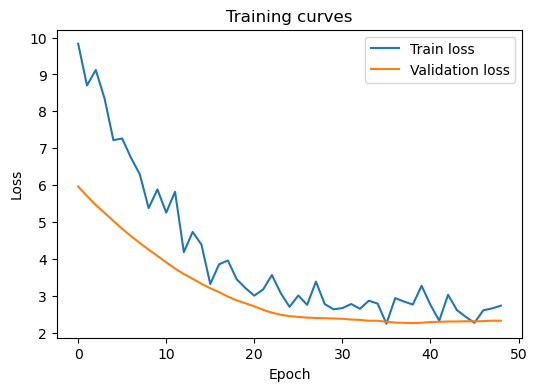

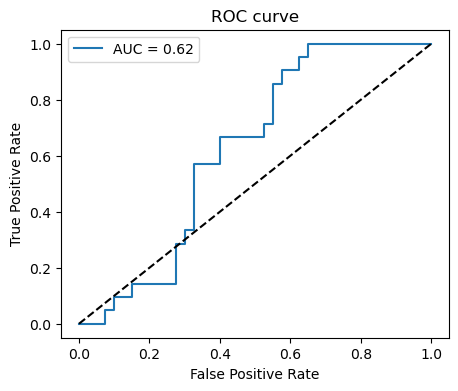

In [40]:
X = Z.loc[y_luma.index]   # latent AE, aligné avec les patients LumA
y = y_luma                # IDC vs ILC

model, history = mlp(
    X=X,
    y=y,
    task="classification",
    hidden_layers=[32],
    dropout=0.2,
    lr=1e-4,
    epochs=200,
    batch_size=32
)

# MLP Balanced

In [48]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score,
    classification_report, confusion_matrix,
    ConfusionMatrixDisplay, roc_auc_score, roc_curve
)

from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


def mlp_balanced(
    X: pd.DataFrame,
    y: pd.Series,
    test_size: float = 0.2,
    seed: int = 42,
    hidden_layers: list = [128, 64],
    dropout: float = 0.3,
    lr: float = 1e-3,
    epochs: int = 200,
    batch_size: int = 32,
    verbose: int = 1
):

    # ======================
    # 1. Data preparation
    # ======================
    X_np = X.values.astype("float32")

    LE = LabelEncoder()
    y_enc = LE.fit_transform(y.values)
    class_names = LE.classes_
    n_classes = len(class_names)

    # ======================
    # 2. Train / validation split
    # ======================
    X_train, X_val, y_train, y_val = train_test_split(
        X_np, y_enc,
        test_size=test_size,
        random_state=seed,
        stratify=y_enc
    )

    print("X_train:", X_train.shape)
    print("X_val:", X_val.shape)
    print("Class distribution (train):", np.bincount(y_train))

    # ======================
    # 3. Class weights (IMPORTANT)
    # ======================
    weights = compute_class_weight(
        class_weight="balanced",
        classes=np.unique(y_train),
        y=y_train
    )
    class_weight = dict(enumerate(weights))

    print("Class weights:", class_weight)

    # ======================
    # 4. Build MLP
    # ======================
    input_dim = X_train.shape[1]
    inputs = layers.Input(shape=(input_dim,))
    z = inputs

    for units in hidden_layers:
        z = layers.Dense(units, activation="relu")(z)
        if dropout > 0:
            z = layers.Dropout(dropout)(z)

    outputs = layers.Dense(1, activation="sigmoid")(z)

    model = models.Model(inputs, outputs, name="mlp_balanced")

    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )

    model.summary()

    # ======================
    # 5. Training
    # ======================
    callbacks = [
        EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
        ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6)
    ]

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        class_weight=class_weight,
        callbacks=callbacks,
        verbose=verbose
    )

    # ======================
    # 6. Evaluation
    # ======================
    y_prob = model.predict(X_val).ravel()
    y_pred = (y_prob >= 0.5).astype(int)

    acc = accuracy_score(y_val, y_pred)
    bacc = balanced_accuracy_score(y_val, y_pred)
    auc = roc_auc_score(y_val, y_prob)

    print("\nAccuracy:", acc)
    print("Balanced accuracy:", bacc)
    print("AUC:", auc)
    print("\nClassification report:")
    print(classification_report(y_val, y_pred, target_names=class_names))

    # Confusion matrix
    cm = confusion_matrix(y_val, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap="Blues", values_format="d")
    plt.title("Confusion Matrix – IDC vs ILC")
    plt.show()

    # ======================
    # 7. Learning curves
    # ======================
    plt.figure(figsize=(6,4))
    plt.plot(history.history["loss"], label="Train loss")
    plt.plot(history.history["val_loss"], label="Validation loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training curves")
    plt.legend()
    plt.show()

    # ======================
    # 8. ROC curve
    # ======================
    fpr, tpr, _ = roc_curve(y_val, y_prob)
    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
    plt.plot([0,1], [0,1], "k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC curve")
    plt.legend()
    plt.show()

    return model, history

X_train: (244, 30)
X_val: (61, 30)
Class distribution (train): [159  85]
Class weights: {0: 0.7672955974842768, 1: 1.4352941176470588}


Model: "mlp_balanced"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_47 (InputLayer)     │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_123 (Dense)               │ (None, 64)             │         1,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_60 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_124 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_61 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_125 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,097 (16.00 KB)

 Trainable params: 4,097 (16.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.3934 - loss: 18.1706 - val_accuracy: 0.4918 - val_loss: 13.9771 - learning_rate: 1.0000e-04
Epoch 2/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.4139 - loss: 18.2318 - val_accuracy: 0.4754 - val_loss: 13.2458 - learning_rate: 1.0000e-04
Epoch 3/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.3607 - loss: 19.9349 - val_accuracy: 0.4918 - val_loss: 12.5327 - learning_rate: 1.0000e-04
Epoch 4/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.3689 - loss: 17.6210 - val_accuracy: 0.4918 - val_loss: 11.8325 - learning_rate: 1.0000e-04
Epoch 5/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.4057 - loss: 17.1126 - val_accuracy: 0.4754 - val_loss: 11.1547 - learning_rate: 1.0000e-04
Epoch 6/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.3484 - loss: 16.3737 - val_accuracy: 0.4426 - val_loss: 10.4874 - learning_rate: 1.0000e-04
Epoch 7/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.

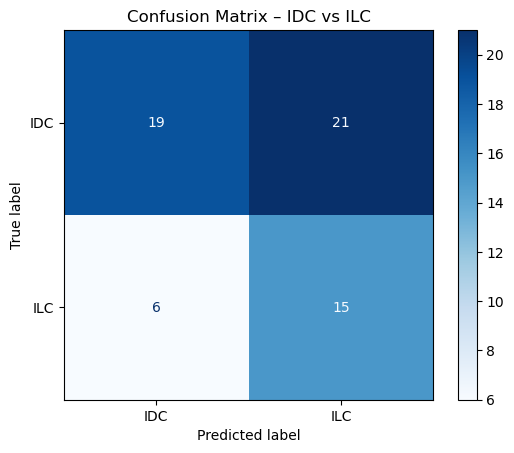

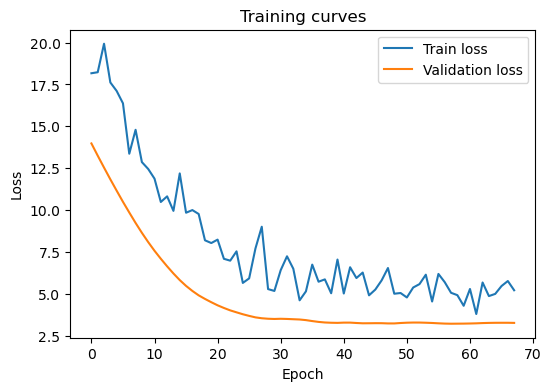

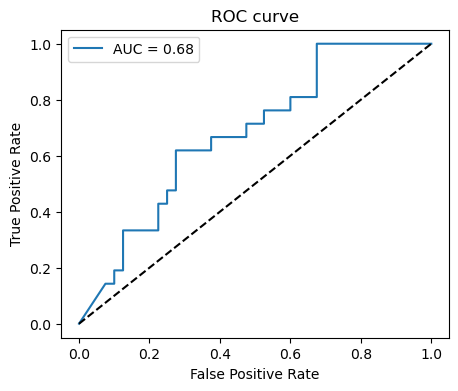

In [73]:
X = Z.loc[y_luma.index]   # latent AE, aligné avec les patients LumA
y = y_luma     

model_balanced , history_balanced = mlp_balanced(
    X=X,
    y=y,
    hidden_layers=[64,32],
    dropout=0.2,
    lr=1e-4,
    batch_size=64
)

# Permutation - based interpretation of the latent space

At this stage, we aimed to understand which biological signals drive the model’s predictions. After training the MLP on the autoencoder latent space, we applied a permutation importance analysis on the latent dimensions. This method measures how much the model’s performance decreases when the values of one latent dimension are randomly shuffled, allowing us to identify the most influential latent features for distinguishing IDC from ILC.

For the most important latent dimensions, we then examined their correlations with the original gene expression profiles. By ranking genes according to their correlation with these informative latent variables, we identified candidate genes contributing to the separation between IDC and ILC. Several of these genes are associated with known biological processes such as ribosomal activity, cytoskeletal organization, extracellular matrix remodeling, and epithelial identity, which are consistent with reported differences between ductal and lobular breast cancers. This approach provides a biologically interpretable link between the deep learning model and gene-level signals.

In [ ]:
def permutation_importance_latent(
    model,
    X: pd.DataFrame,
    y: pd.Series,
    n_repeats: int = 10,
    seed: int = 42
):
    import numpy as np
    import pandas as pd
    from sklearn.metrics import balanced_accuracy_score

    rng = np.random.RandomState(seed)

    # Encodage binaire
    y_bin = (y == "ILC").astype(int).values
    X_np = X.values

    # Performance de référence
    y_prob_ref = model.predict(X_np, verbose=0).ravel()
    y_pred_ref = (y_prob_ref >= 0.5).astype(int)
    baseline = balanced_accuracy_score(y_bin, y_pred_ref)

    importances = []

    for j, col in enumerate(X.columns):
        scores = []

        for _ in range(n_repeats):
            X_perm = X_np.copy()
            perm_idx = rng.permutation(len(X_perm))
            X_perm[:, j] = X_perm[perm_idx, j]

            y_prob = model.predict(X_perm, verbose=0).ravel()
            y_pred = (y_prob >= 0.5).astype(int)
            scores.append(balanced_accuracy_score(y_bin, y_pred))

        importance = baseline - np.mean(scores)
        importances.append(importance)

    # TRI PAR IMPORTANCE DÉCROISSANTE
    importance_df = (
        pd.DataFrame({
            "latent_dim": X.columns,
            "importance": importances
        })
        .sort_values("importance", ascending=False)
        .reset_index(drop=True)
    )

    return importance_df

In [ ]:
X = Z.loc[y_luma.index]   # latent AE aligné avec les patients LumA
y = y_luma  

latent_importance = permutation_importance_latent(
    model=model_balanced,
    X=X,
    y=y,
    n_repeats=20
)

latent_importance.head(10)

,latent_dim,importance
0,z20,0.174298
1,z13,0.051797
2,z6,0.045178
3,z26,0.040150
4,z12,0.021911
5,z24,0.014861
6,z29,0.013710
7,z5,0.013075
8,z22,0.012782
9,z11,0.012590


In [97]:
top_Z = latent_importance["latent_dim"].head(10).tolist()
top_Z

['z20', 'z13', 'z6', 'z26', 'z12', 'z24', 'z29', 'z5', 'z22', 'z11']

/var/folders/gy/bwg3l6_55tq1pzm0qdpfw_w80000gn/T/ipykernel_30722/1455206580.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


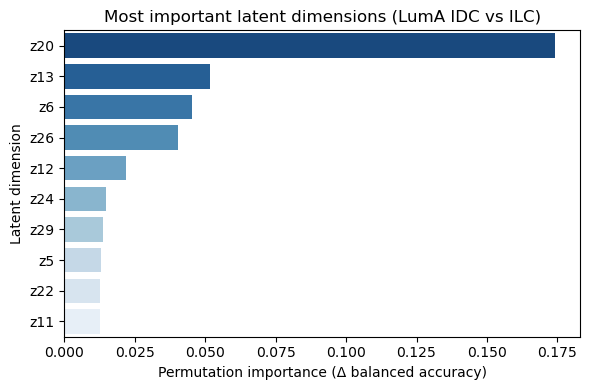

In [98]:
top = latent_importance.head(10)

plt.figure(figsize=(6,4))
sns.barplot(
    data= top,
    x="importance",
    y="latent_dim",
    palette="Blues_r"
)
plt.xlabel("Permutation importance (Δ balanced accuracy)")
plt.ylabel("Latent dimension")
plt.title("Most important latent dimensions (LumA IDC vs ILC)")
plt.tight_layout()
plt.show()

In [78]:
def genes_associated_with_Z(Z, X_expr, z_name, top_n=30):
    """
    Associe une dimension latente Z à ses gènes les plus corrélés
    """
    z = Z[z_name]
    corrs = X_expr.apply(lambda g: g.corr(z), axis=0)
    corrs = corrs.dropna().abs().sort_values(ascending=False)
    return corrs.head(top_n)

In [ ]:
for z in top_Z:
    print(f"\n=== Gènes associés à {z} ===")
    display(
        genes_associated_with_Z(
            Z=X,  # latent LumA
            X_expr=X_luma.loc[X.index],
            z_name=z,
            top_n=20
        )
    ) 


=== Gènes associés à z20 ===


NOP53       0.789975
RPS9        0.717907
RPS28       0.717832
RPS15       0.711111
RPL13       0.692549
NUFIP2      0.688973
RPL35       0.688370
RPLP2       0.687622
TAOK1       0.682581
PTBP3       0.678601
CDC42EP1    0.678157
RPL18       0.677376
AFF4        0.674102
RPL18A      0.670441
RPL36       0.666320
CIRBP       0.656843
USP9X       0.656409
NCKAP1      0.655453
CKAP5       0.654094
RPS19       0.647550
dtype: float64


=== Gènes associés à z13 ===


EEF1B2    0.706449
RPL5      0.682759
RPL11     0.677681
RPS7      0.677028
RPS25     0.672701
RPS27A    0.669668
EGFR      0.649658
MFGE8     0.644034
RPL13     0.637382
YBX1      0.637017
RPS3A     0.625754
PRNP      0.617418
RPL34     0.612239
RPLP2     0.610956
RPS8      0.610676
AQP1      0.610497
RPL9      0.609291
RPL6      0.609206
RPL10A    0.607640
EIF3D     0.606017
dtype: float64


=== Gènes associés à z6 ===


TPI1      0.609316
CCT3      0.569877
GFUS      0.565229
ILF2      0.537825
GAPDH     0.529849
IDH2      0.517963
CYC1      0.514694
TGFBR2    0.514344
VDAC1     0.511492
CD34      0.496880
NDUFB9    0.496736
AQP1      0.495184
AHNAK     0.483701
PECAM1    0.479987
PKM       0.476902
LDHA      0.476017
SPTBN1    0.475881
CCT6A     0.475500
RPS2      0.473744
CRIM1     0.472857
dtype: float64


=== Gènes associés à z26 ===


CNN2        0.662935
ZYX         0.648388
COL16A1     0.640553
MRC2        0.637875
MXRA8       0.618612
FSCN1       0.617959
CDC42EP1    0.617358
LRBA        0.612361
C1R         0.604879
CANX        0.601591
COL6A2      0.597868
MMP2        0.591713
ESR1        0.586697
MYL9        0.586333
PTBP3       0.574206
HTRA1       0.570529
TBC1D9      0.568626
ISLR        0.565789
MED13L      0.564981
PANK3       0.561503
dtype: float64


=== Gènes associés à z12 ===


EDF1      0.741291
RPL28     0.733918
DDX3X     0.718743
RPL18     0.715558
RPS15     0.715157
RPS2      0.715105
RPL35     0.714150
TRIP12    0.710357
GUK1      0.705698
FAU       0.700755
RALY      0.694850
PIK3CA    0.693057
SON       0.691592
PRDX5     0.688173
RHOC      0.685499
PJA2      0.682645
TAOK1     0.679059
RPS19     0.672715
SERF2     0.670472
RPL36     0.670439
dtype: float64


=== Gènes associés à z24 ===


RPLP2     0.786604
AFF4      0.755409
CD81      0.749052
RPL35     0.727386
RPL13     0.714720
UBA52     0.694376
RPS9      0.693787
FAU       0.690212
COX4I1    0.688244
RPL37A    0.687764
GPX1      0.686961
RPS28     0.686220
RPS15     0.674511
RPL18A    0.673245
RPL27A    0.672895
RPS16     0.666352
RPS19     0.663168
RPL18     0.660987
CYB5R3    0.660702
RPL28     0.660489
dtype: float64


=== Gènes associés à z29 ===


CAVIN1      0.864836
ANGPTL2     0.808414
GSN         0.794994
VIM         0.790924
CYB5R3      0.790713
TGFBR2      0.790215
ANXA1       0.783928
SERPINF1    0.776783
LRP1        0.775871
SERPING1    0.773732
EHD2        0.768391
CD34        0.764770
FBLN5       0.763487
FBLN2       0.756892
CCDC80      0.749909
PECAM1      0.733463
LAMA4       0.731211
C1S         0.731058
DCN         0.724911
TMBIM1      0.724144
dtype: float64


=== Gènes associés à z5 ===


RPS2        0.701937
RPL8        0.689457
MBNL1       0.673115
RPS24       0.649095
RPLP1       0.647857
EIF3I       0.634195
RPL29       0.628766
VPS28       0.624592
RPL18       0.623983
RPS16       0.618632
RPL7A       0.614450
SLC25A39    0.611247
RPS8        0.610798
PPIA        0.607862
RPL36       0.605936
RPL28       0.604287
RPL27A      0.603195
RPL35       0.602418
SNRPD2      0.601947
RPL12       0.601897
dtype: float64


=== Gènes associés à z22 ===


IGF2R      0.636158
HSPG2      0.593401
PARK7      0.587031
RPS24      0.546161
SRP14      0.541597
ATP5MC2    0.537877
RPL24      0.535175
RPL14      0.532830
MAP4K4     0.528341
TLN1       0.524606
EIF3I      0.524387
SNRPD2     0.522206
PRRC2B     0.521447
SERF2      0.517270
MYL12B     0.514006
DYNC1H1    0.513320
RPL38      0.512694
NACA       0.502485
RPLP1      0.499271
RPL12      0.498127
dtype: float64


=== Gènes associés à z11 ===


RPLP2     0.615385
RPS7      0.606350
RPS24     0.595927
RPL39     0.594719
RPS20     0.591068
RPL27A    0.585319
RPL38     0.582778
TKT       0.581826
RPS13     0.577378
RPL11     0.573226
RPL32     0.569097
RPS16     0.567582
RPS8      0.567167
RPL4      0.561770
RPL6      0.561364
RPLP0     0.559633
CD81      0.556122
RPL24     0.552854
RPL9      0.549463
RPL12     0.547946
dtype: float64

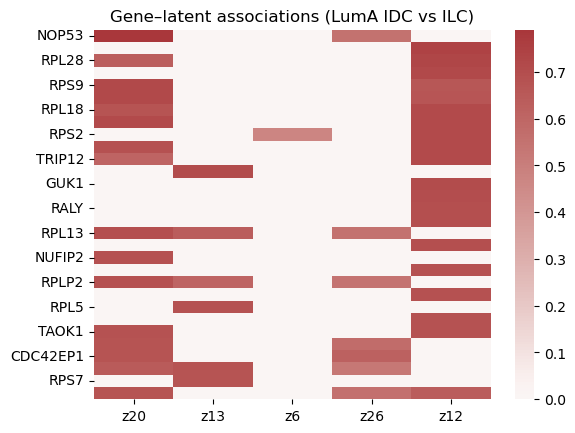

In [91]:
Z_sel = top_Z

genes_corr = pd.DataFrame({
    z: genes_associated_with_Z(
        Z=X,
        X_expr=X_luma.loc[X.index],
        z_name=z,
        top_n=50
    )
    for z in Z_sel
}).fillna(0)

top_genes = (
    genes_corr.abs().max(axis=1)
    .sort_values(ascending=False)
    .head(30)
    .index
)

sns.heatmap(
    genes_corr.loc[top_genes, Z_sel],
    cmap="vlag",
    center=0
)
plt.title("Gene–latent associations (LumA IDC vs ILC)")
plt.show()

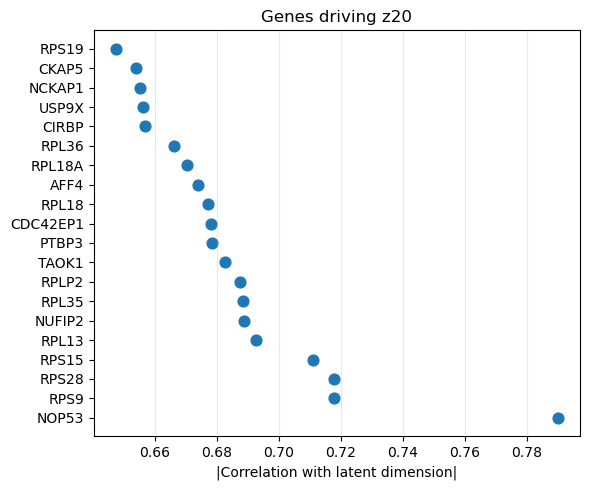

In [93]:
df = gene_scores.reset_index()
df.columns = ["Gene", "Correlation"]

plt.figure(figsize=(6,5))
plt.scatter(df["Correlation"], df["Gene"], s=60)
plt.xlabel("|Correlation with latent dimension|")
plt.title(f"Genes driving {z_name}")
plt.grid(axis="x", alpha=0.3)
plt.tight_layout()
plt.show()

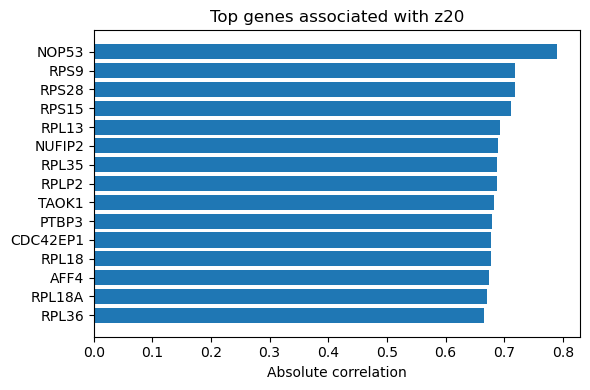

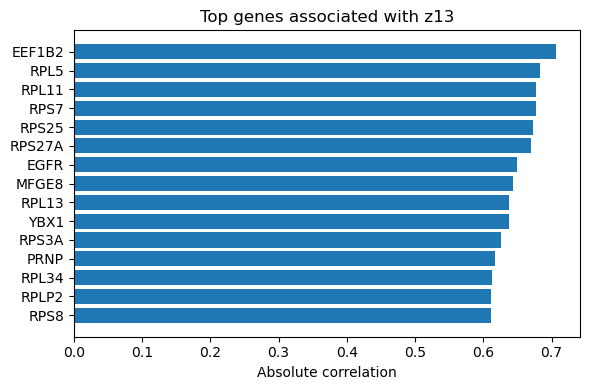

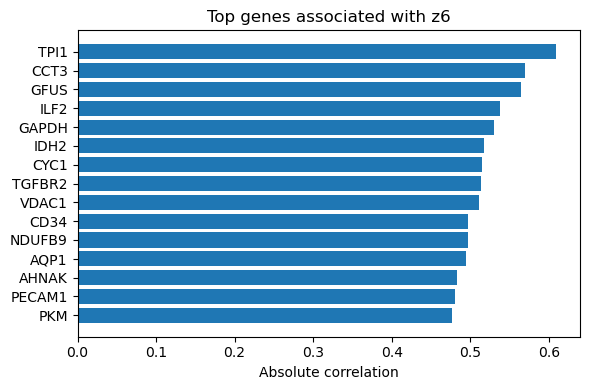

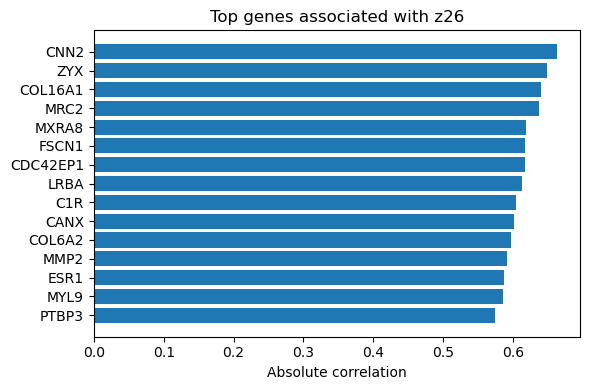

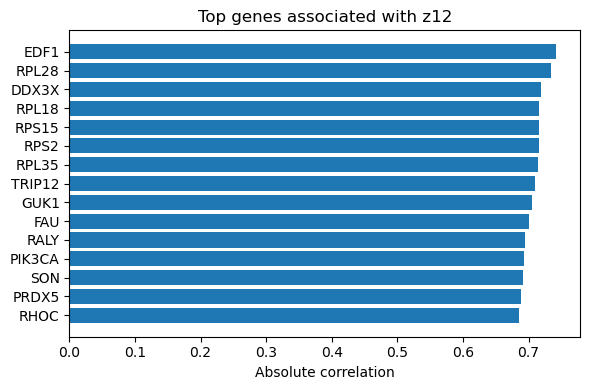

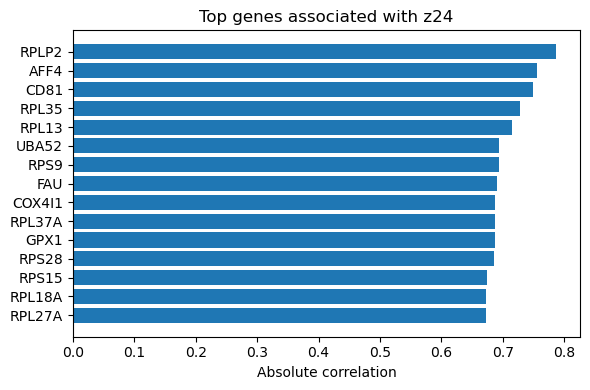

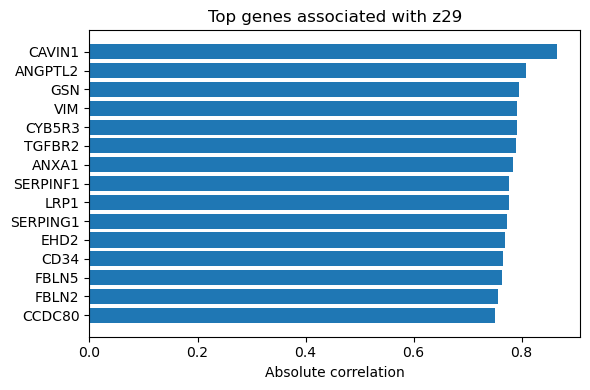

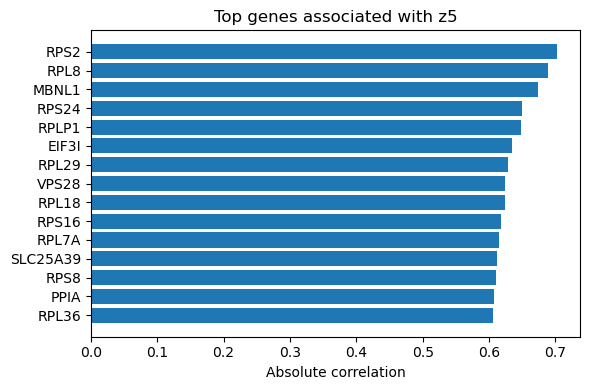

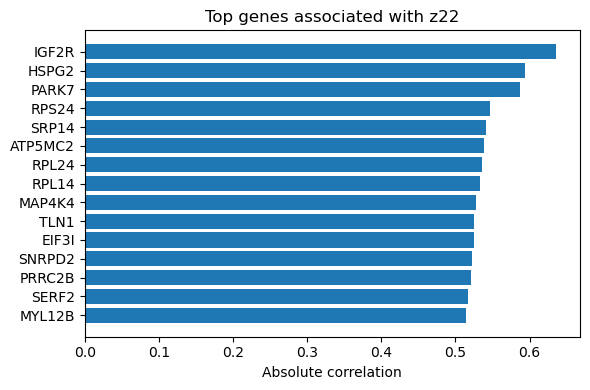

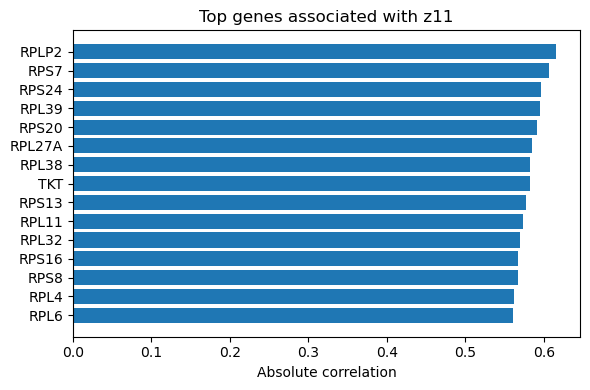

In [100]:
for z in top_Z:
    # récupérer les gènes les plus corrélés à la dimension z
    genes = genes_associated_with_Z(
        Z=X,                       # latent (LumA IDC/ILC)
        X_expr=X_luma.loc[X.index],# RNA-seq correspondant
        z_name=z,
        top_n=15
    )

    # bar plot
    plt.figure(figsize=(6,4))
    plt.barh(genes.index[::-1], genes.values[::-1])
    plt.xlabel("Absolute correlation")
    plt.title(f"Top genes associated with {z}")
    plt.tight_layout()
    plt.show()

# Classification by using cross fold 

In [44]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    roc_auc_score,
    balanced_accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    RocCurveDisplay
)
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


def mlp_cv_balanced(
    X: pd.DataFrame,
    y: pd.Series,
    covariates: pd.DataFrame | None = None,   # 👈 pour plus tard
    hidden_layers=[64, 32],
    dropout=0.3,
    lr=1e-4,
    epochs=200,
    batch_size=64,
    n_splits=5,
    seed=42
):
    # ---------- DATA ----------
    X_main = X.values.astype("float32")

    if covariates is not None:
        cov = covariates.loc[X.index].values.astype("float32")
        X_all = np.hstack([X_main, cov])
        print(f"→ X avec covariables : {X_all.shape}")
    else:
        X_all = X_main
        print(f"→ X sans covariables : {X_all.shape}")

    # ---------- LABELS ----------
    LE = LabelEncoder()
    y_enc = LE.fit_transform(y.values)
    class_names = LE.classes_

    # ---------- CLASS WEIGHTS ----------
    weights = compute_class_weight(
        class_weight="balanced",
        classes=np.unique(y_enc),
        y=y_enc
    )
    class_weight = dict(zip(np.unique(y_enc), weights))

    # ---------- CV ----------
    skf = StratifiedKFold(
        n_splits=n_splits,
        shuffle=True,
        random_state=seed
    )

    aucs, baccs = [], []
    mean_cm = np.zeros((2, 2))

    plt.figure(figsize=(6, 5))

    for fold, (train_idx, val_idx) in enumerate(skf.split(X_all, y_enc)):
        print(f"\n=== Fold {fold+1}/{n_splits} ===")

        X_train, X_val = X_all[train_idx], X_all[val_idx]
        y_train, y_val = y_enc[train_idx], y_enc[val_idx]

        # ---------- MODEL ----------
        inputs = layers.Input(shape=(X_train.shape[1],))
        z = inputs
        for units in hidden_layers:
            z = layers.Dense(units, activation="relu")(z)
            z = layers.Dropout(dropout)(z)

        outputs = layers.Dense(1, activation="sigmoid")(z)
        model = models.Model(inputs, outputs)

        model.compile(
            optimizer=Adam(learning_rate=lr),
            loss="binary_crossentropy"
        )

        model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            class_weight=class_weight,
            callbacks=[
                EarlyStopping(
                    monitor="val_loss",
                    patience=10,
                    restore_best_weights=True
                )
            ],
            verbose=0
        )

        # ---------- EVAL ----------
        y_prob = model.predict(X_val).ravel()
        y_pred = (y_prob >= 0.5).astype(int)

        auc = roc_auc_score(y_val, y_prob)
        bacc = balanced_accuracy_score(y_val, y_pred)

        aucs.append(auc)
        baccs.append(bacc)

        mean_cm += confusion_matrix(y_val, y_pred)

        RocCurveDisplay.from_predictions(
            y_val,
            y_prob,
            name=f"Fold {fold+1}",
            alpha=0.6
        )

        print(f"AUC={auc:.3f} | Balanced acc={bacc:.3f}")

    # ---------- ROC ----------
    plt.plot([0, 1], [0, 1], "k--")
    plt.title("ROC curves – 5-fold CV")
    plt.show()

    # ---------- CONFUSION MATRIX ----------
    mean_cm /= n_splits
    disp = ConfusionMatrixDisplay(
        confusion_matrix=mean_cm,
        display_labels=class_names
    )
    disp.plot(cmap="Blues", values_format=".1f")
    plt.title("Mean confusion matrix (CV)")
    plt.show()

    # ---------- SCORE DISTRIBUTION ----------
    plt.figure(figsize=(5, 4))
    plt.boxplot([aucs, baccs], labels=["AUC", "Balanced acc"])
    plt.title("Cross-validated performance")
    plt.show()

    print("\n===== FINAL RESULTS =====")
    print(f"AUC : {np.mean(aucs):.3f} ± {np.std(aucs):.3f}")
    print(f"Balanced acc : {np.mean(baccs):.3f} ± {np.std(baccs):.3f}")

    return aucs, baccs

→ X sans covariables : (305, 30)

=== Fold 1/5 ===
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
AUC=0.740 | Balanced acc=0.681

=== Fold 2/5 ===


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/_plotting.py:175: FutureWarning: `**kwargs` is deprecated and will be removed in 1.9. Pass all matplotlib arguments to `curve_kwargs` as a dictionary instead.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
AUC=0.863 | Balanced acc=0.839

=== Fold 3/5 ===


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/_plotting.py:175: FutureWarning: `**kwargs` is deprecated and will be removed in 1.9. Pass all matplotlib arguments to `curve_kwargs` as a dictionary instead.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
AUC=0.714 | Balanced acc=0.618

=== Fold 4/5 ===


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/_plotting.py:175: FutureWarning: `**kwargs` is deprecated and will be removed in 1.9. Pass all matplotlib arguments to `curve_kwargs` as a dictionary instead.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
AUC=0.785 | Balanced acc=0.742

=== Fold 5/5 ===


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/_plotting.py:175: FutureWarning: `**kwargs` is deprecated and will be removed in 1.9. Pass all matplotlib arguments to `curve_kwargs` as a dictionary instead.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
AUC=0.673 | Balanced acc=0.607


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/_plotting.py:175: FutureWarning: `**kwargs` is deprecated and will be removed in 1.9. Pass all matplotlib arguments to `curve_kwargs` as a dictionary instead.
  warnings.warn(


<Figure size 600x500 with 0 Axes>

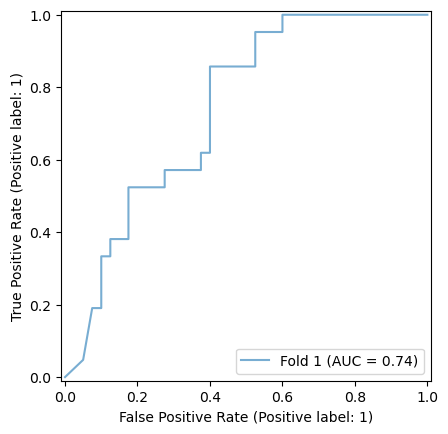

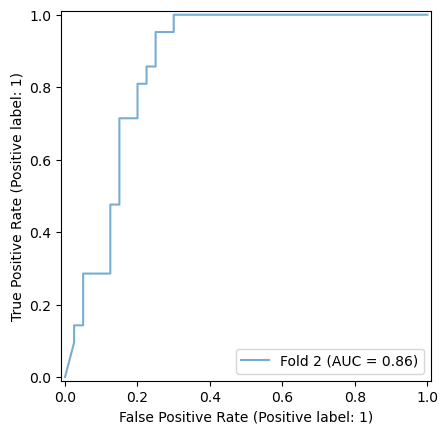

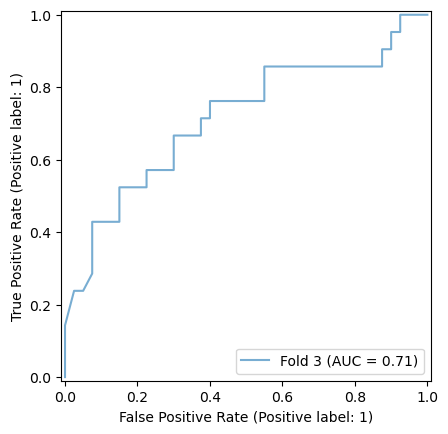

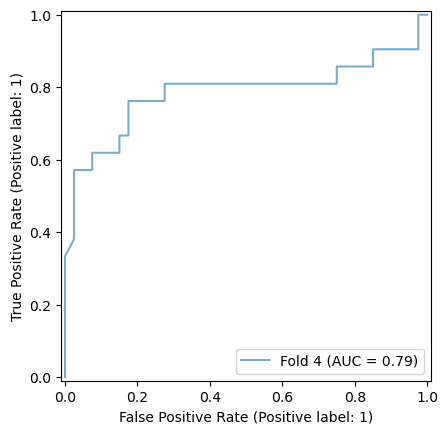

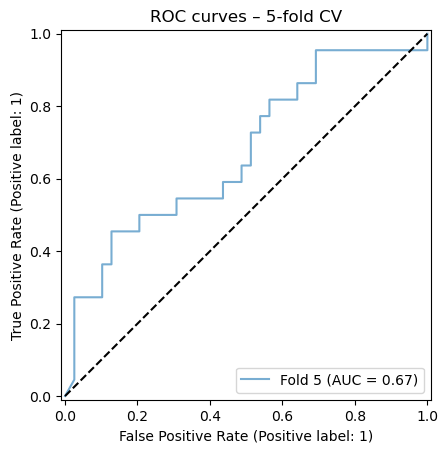

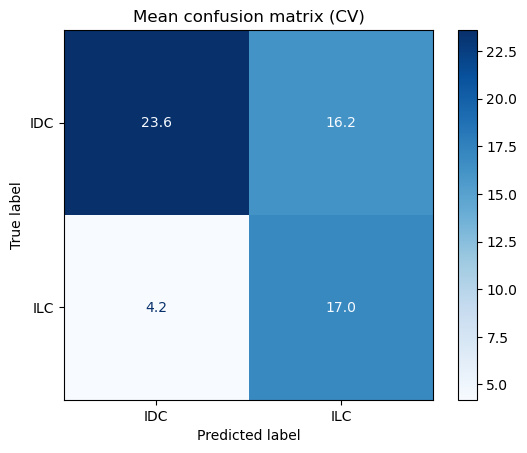

/var/folders/gy/bwg3l6_55tq1pzm0qdpfw_w80000gn/T/ipykernel_30722/1495517296.py:142: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([aucs, baccs], labels=["AUC", "Balanced acc"])


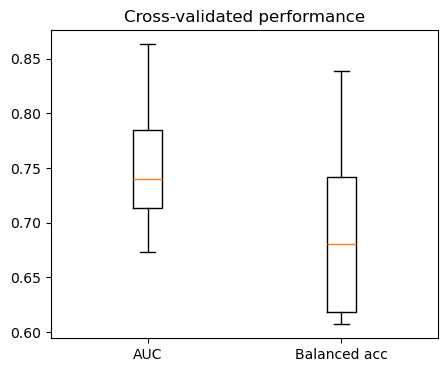


===== FINAL RESULTS =====
AUC : 0.755 ± 0.065
Balanced acc : 0.698 ± 0.086


In [80]:
X = Z.loc[y_luma.index]   # latent AE, aligné avec les patients LumA
y = y_luma   

model_cv, history_cv = mlp_cv_balanced(
    X=X,
    y=y,
    hidden_layers=[32],
    dropout=0.2,
    lr=1e-4,
    batch_size=64
)

# # Permutation - based interpretation of the latent space

In [109]:
X = Z.loc[y_luma.index]  
y = y_luma  

latent_importance_cv = permutation_importance_latent(
    model=model_cv,
    X=X,
    y=y,
    n_repeats=20
)

latent_importance_cv.head(10)

AttributeError: 'list' object has no attribute 'predict'

In [101]:
top_Z_cv = latent_importance["latent_dim"].head(10).tolist()
top_Z_cv

['z20', 'z13', 'z6', 'z26', 'z12', 'z24', 'z29', 'z5', 'z22', 'z11']

In [102]:
for z in top_Z_cv:
    print(f"\n=== Gènes associés à {z} ===")
    display(
        genes_associated_with_Z(
            Z=X,  # latent LumA
            X_expr=X_luma.loc[X.index],
            z_name=z,
            top_n=20
        )
    )


=== Gènes associés à z20 ===


NOP53       0.789975
RPS9        0.717907
RPS28       0.717832
RPS15       0.711111
RPL13       0.692549
NUFIP2      0.688973
RPL35       0.688370
RPLP2       0.687622
TAOK1       0.682581
PTBP3       0.678601
CDC42EP1    0.678157
RPL18       0.677376
AFF4        0.674102
RPL18A      0.670441
RPL36       0.666320
CIRBP       0.656843
USP9X       0.656409
NCKAP1      0.655453
CKAP5       0.654094
RPS19       0.647550
dtype: float64


=== Gènes associés à z13 ===


EEF1B2    0.706449
RPL5      0.682759
RPL11     0.677681
RPS7      0.677028
RPS25     0.672701
RPS27A    0.669668
EGFR      0.649658
MFGE8     0.644034
RPL13     0.637382
YBX1      0.637017
RPS3A     0.625754
PRNP      0.617418
RPL34     0.612239
RPLP2     0.610956
RPS8      0.610676
AQP1      0.610497
RPL9      0.609291
RPL6      0.609206
RPL10A    0.607640
EIF3D     0.606017
dtype: float64


=== Gènes associés à z6 ===


TPI1      0.609316
CCT3      0.569877
GFUS      0.565229
ILF2      0.537825
GAPDH     0.529849
IDH2      0.517963
CYC1      0.514694
TGFBR2    0.514344
VDAC1     0.511492
CD34      0.496880
NDUFB9    0.496736
AQP1      0.495184
AHNAK     0.483701
PECAM1    0.479987
PKM       0.476902
LDHA      0.476017
SPTBN1    0.475881
CCT6A     0.475500
RPS2      0.473744
CRIM1     0.472857
dtype: float64


=== Gènes associés à z26 ===


CNN2        0.662935
ZYX         0.648388
COL16A1     0.640553
MRC2        0.637875
MXRA8       0.618612
FSCN1       0.617959
CDC42EP1    0.617358
LRBA        0.612361
C1R         0.604879
CANX        0.601591
COL6A2      0.597868
MMP2        0.591713
ESR1        0.586697
MYL9        0.586333
PTBP3       0.574206
HTRA1       0.570529
TBC1D9      0.568626
ISLR        0.565789
MED13L      0.564981
PANK3       0.561503
dtype: float64


=== Gènes associés à z12 ===


EDF1      0.741291
RPL28     0.733918
DDX3X     0.718743
RPL18     0.715558
RPS15     0.715157
RPS2      0.715105
RPL35     0.714150
TRIP12    0.710357
GUK1      0.705698
FAU       0.700755
RALY      0.694850
PIK3CA    0.693057
SON       0.691592
PRDX5     0.688173
RHOC      0.685499
PJA2      0.682645
TAOK1     0.679059
RPS19     0.672715
SERF2     0.670472
RPL36     0.670439
dtype: float64


=== Gènes associés à z24 ===


RPLP2     0.786604
AFF4      0.755409
CD81      0.749052
RPL35     0.727386
RPL13     0.714720
UBA52     0.694376
RPS9      0.693787
FAU       0.690212
COX4I1    0.688244
RPL37A    0.687764
GPX1      0.686961
RPS28     0.686220
RPS15     0.674511
RPL18A    0.673245
RPL27A    0.672895
RPS16     0.666352
RPS19     0.663168
RPL18     0.660987
CYB5R3    0.660702
RPL28     0.660489
dtype: float64


=== Gènes associés à z29 ===


CAVIN1      0.864836
ANGPTL2     0.808414
GSN         0.794994
VIM         0.790924
CYB5R3      0.790713
TGFBR2      0.790215
ANXA1       0.783928
SERPINF1    0.776783
LRP1        0.775871
SERPING1    0.773732
EHD2        0.768391
CD34        0.764770
FBLN5       0.763487
FBLN2       0.756892
CCDC80      0.749909
PECAM1      0.733463
LAMA4       0.731211
C1S         0.731058
DCN         0.724911
TMBIM1      0.724144
dtype: float64


=== Gènes associés à z5 ===


RPS2        0.701937
RPL8        0.689457
MBNL1       0.673115
RPS24       0.649095
RPLP1       0.647857
EIF3I       0.634195
RPL29       0.628766
VPS28       0.624592
RPL18       0.623983
RPS16       0.618632
RPL7A       0.614450
SLC25A39    0.611247
RPS8        0.610798
PPIA        0.607862
RPL36       0.605936
RPL28       0.604287
RPL27A      0.603195
RPL35       0.602418
SNRPD2      0.601947
RPL12       0.601897
dtype: float64


=== Gènes associés à z22 ===


IGF2R      0.636158
HSPG2      0.593401
PARK7      0.587031
RPS24      0.546161
SRP14      0.541597
ATP5MC2    0.537877
RPL24      0.535175
RPL14      0.532830
MAP4K4     0.528341
TLN1       0.524606
EIF3I      0.524387
SNRPD2     0.522206
PRRC2B     0.521447
SERF2      0.517270
MYL12B     0.514006
DYNC1H1    0.513320
RPL38      0.512694
NACA       0.502485
RPLP1      0.499271
RPL12      0.498127
dtype: float64


=== Gènes associés à z11 ===


RPLP2     0.615385
RPS7      0.606350
RPS24     0.595927
RPL39     0.594719
RPS20     0.591068
RPL27A    0.585319
RPL38     0.582778
TKT       0.581826
RPS13     0.577378
RPL11     0.573226
RPL32     0.569097
RPS16     0.567582
RPS8      0.567167
RPL4      0.561770
RPL6      0.561364
RPLP0     0.559633
CD81      0.556122
RPL24     0.552854
RPL9      0.549463
RPL12     0.547946
dtype: float64

/var/folders/gy/bwg3l6_55tq1pzm0qdpfw_w80000gn/T/ipykernel_30722/3600826155.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


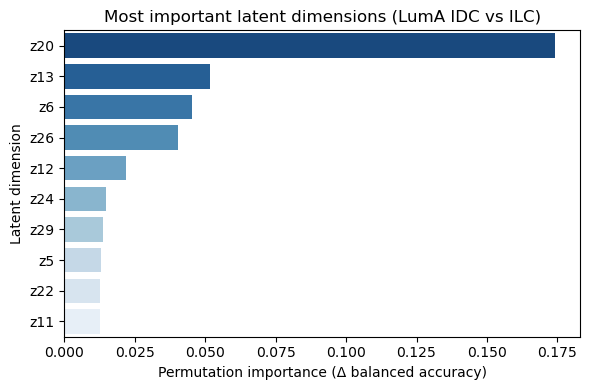

In [104]:
top_cv = latent_importance_cv.head(10)

plt.figure(figsize=(6,4))
sns.barplot(
    data= top_cv,
    x="importance",
    y="latent_dim",
    palette="Blues_r"
)
plt.xlabel("Permutation importance (Δ balanced accuracy)")
plt.ylabel("Latent dimension")
plt.title("Most important latent dimensions (LumA IDC vs ILC)")
plt.tight_layout()
plt.show()

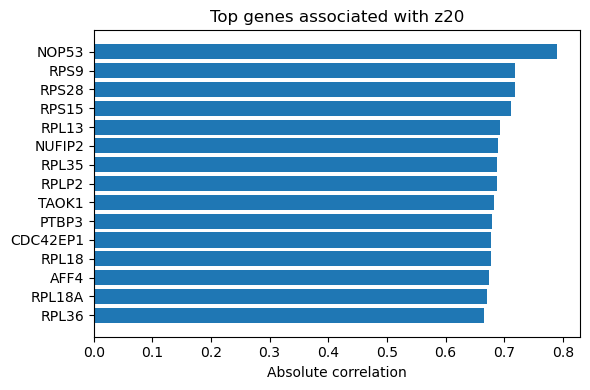

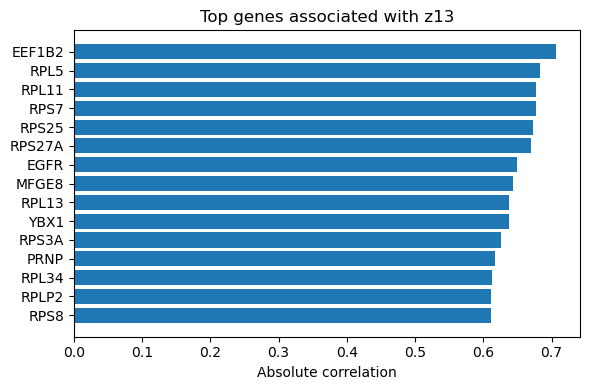

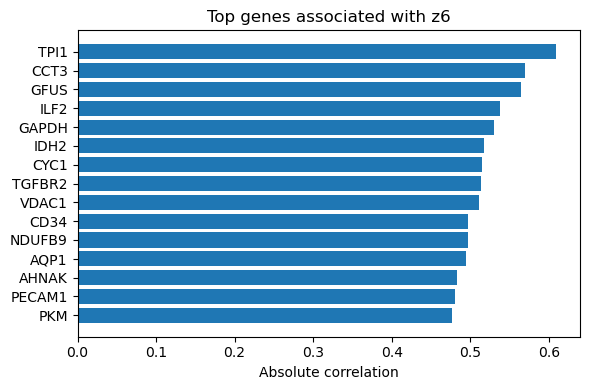

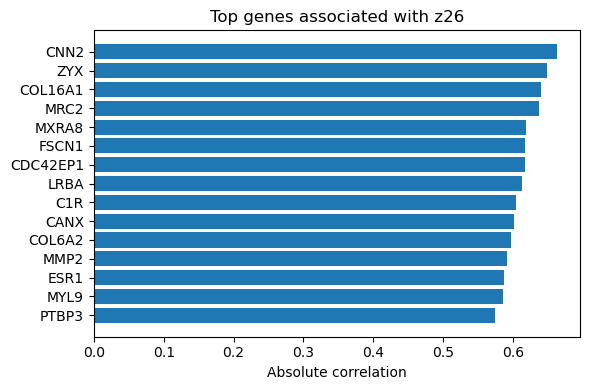

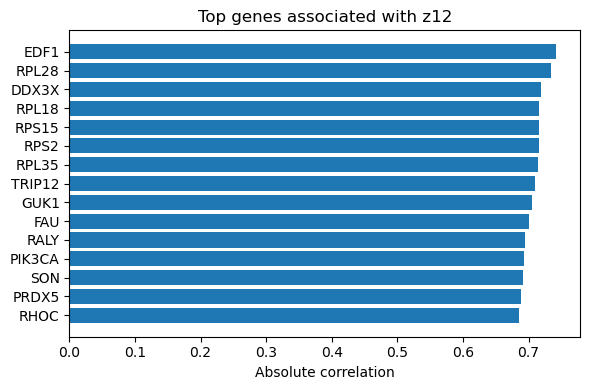

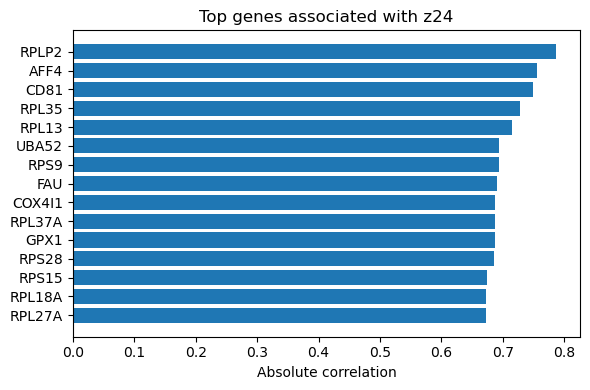

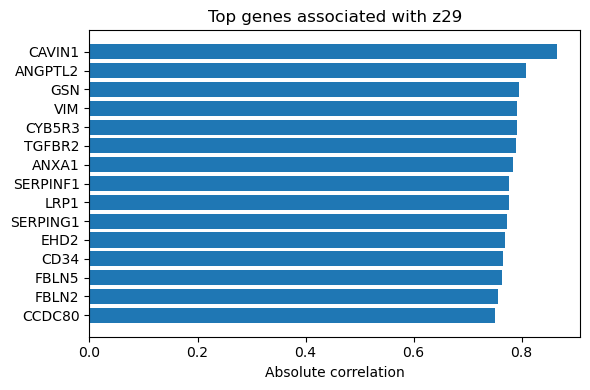

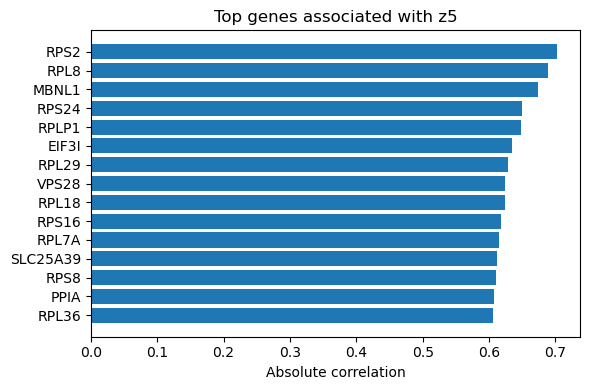

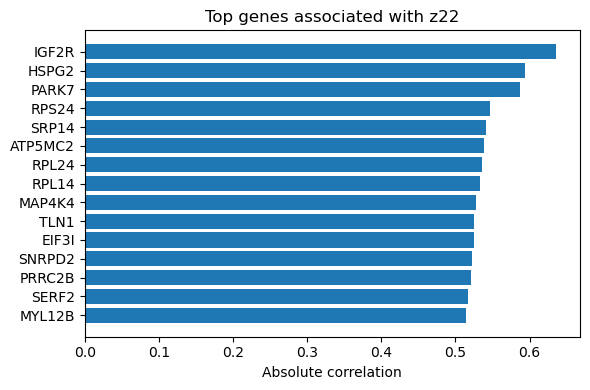

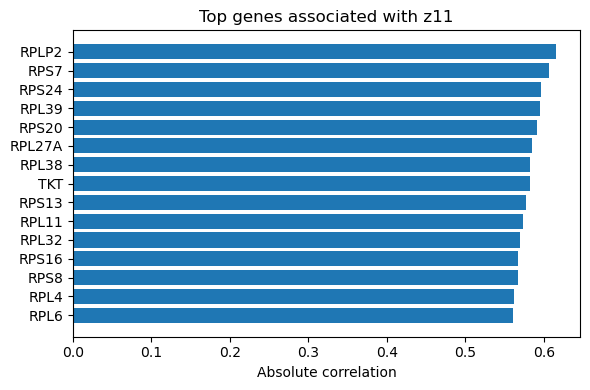

In [105]:
for z in top_Z_cv:
    # récupérer les gènes les plus corrélés à la dimension z
    genes = genes_associated_with_Z(
        Z=X,                       # latent (LumA IDC/ILC)
        X_expr=X_luma.loc[X.index],# RNA-seq correspondant
        z_name=z,
        top_n=15
    )

    # bar plot
    plt.figure(figsize=(6,4))
    plt.barh(genes.index[::-1], genes.values[::-1])
    plt.xlabel("Absolute correlation")
    plt.title(f"Top genes associated with {z}")
    plt.tight_layout()
    plt.show()

# Classification of LumA IDC vs ILC by adding 2 covariates

X_train: (224, 32)
X_val: (57, 32)
Class distribution (train): [153  71]
Class weights: {0: 0.7320261437908496, 1: 1.5774647887323943}


Model: "mlp_balanced"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_61 (InputLayer)     │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_160 (Dense)               │ (None, 128)            │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_83 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_161 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_84 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_162 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,545 (49.00 KB)

 Trainable params: 12,545 (49.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.5357 - loss: 8.3022 - val_accuracy: 0.7018 - val_loss: 3.7360 - learning_rate: 0.0010
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6250 - loss: 6.3281 - val_accuracy: 0.6140 - val_loss: 3.8310 - learning_rate: 0.0010
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5804 - loss: 6.2011 - val_accuracy: 0.5614 - val_loss: 4.2824 - learning_rate: 0.0010
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6161 - loss: 4.5932 - val_accuracy: 0.6316 - val_loss: 4.4260 - learning_rate: 0.0010
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6920 - loss: 3.7888 - val_accuracy: 0.7193 - val_loss: 4.3370 - learning_rate: 0.0010
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6830 - loss: 4.5365 - val_accuracy: 0.7018 - val_loss: 3.9362 - learning_rate: 0.0010
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7054 - loss: 3.9222 - val_accuracy: 

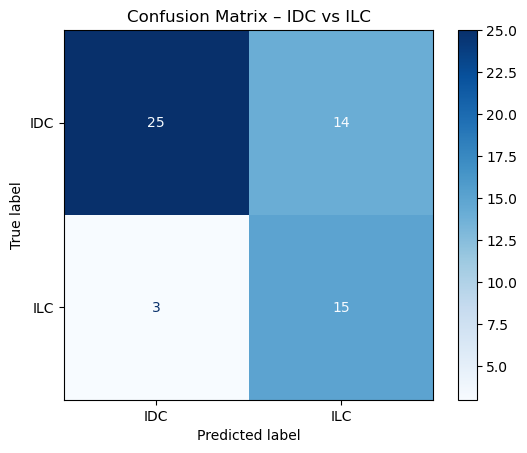

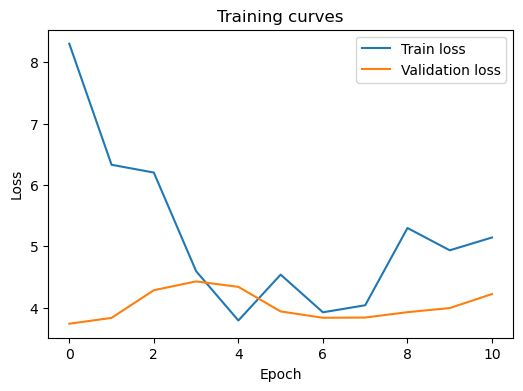

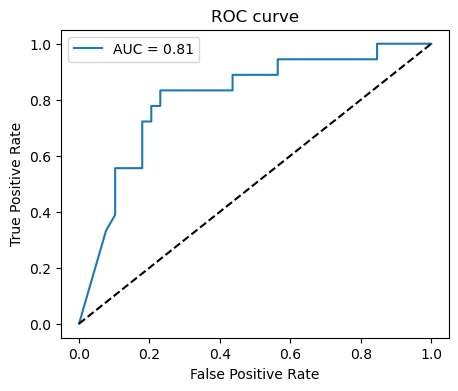

→ X sans covariables : (281, 32)

=== Fold 1/5 ===
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
AUC=0.722 | Balanced acc=0.615

=== Fold 2/5 ===


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/_plotting.py:175: FutureWarning: `**kwargs` is deprecated and will be removed in 1.9. Pass all matplotlib arguments to `curve_kwargs` as a dictionary instead.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
AUC=0.642 | Balanced acc=0.598

=== Fold 3/5 ===


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/_plotting.py:175: FutureWarning: `**kwargs` is deprecated and will be removed in 1.9. Pass all matplotlib arguments to `curve_kwargs` as a dictionary instead.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
AUC=0.817 | Balanced acc=0.788

=== Fold 4/5 ===


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/_plotting.py:175: FutureWarning: `**kwargs` is deprecated and will be removed in 1.9. Pass all matplotlib arguments to `curve_kwargs` as a dictionary instead.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
AUC=0.644 | Balanced acc=0.594

=== Fold 5/5 ===


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/_plotting.py:175: FutureWarning: `**kwargs` is deprecated and will be removed in 1.9. Pass all matplotlib arguments to `curve_kwargs` as a dictionary instead.
  warnings.warn(


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
AUC=0.861 | Balanced acc=0.816


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/_plotting.py:175: FutureWarning: `**kwargs` is deprecated and will be removed in 1.9. Pass all matplotlib arguments to `curve_kwargs` as a dictionary instead.
  warnings.warn(


<Figure size 600x500 with 0 Axes>

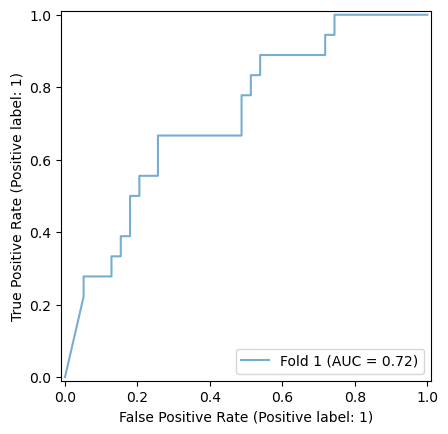

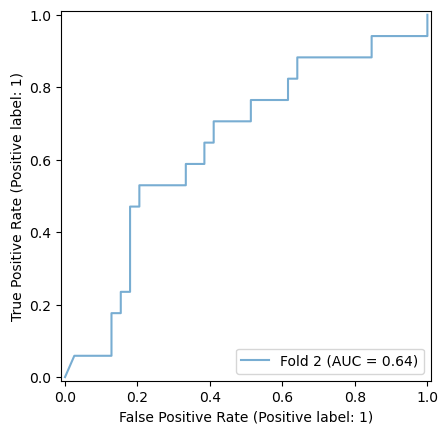

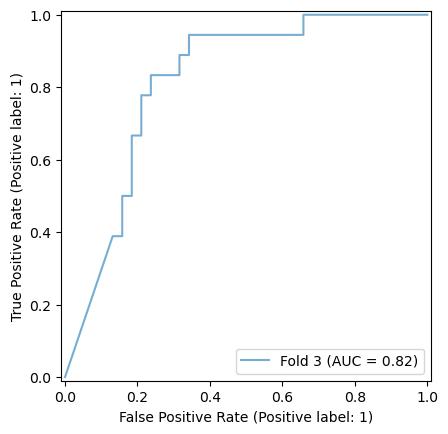

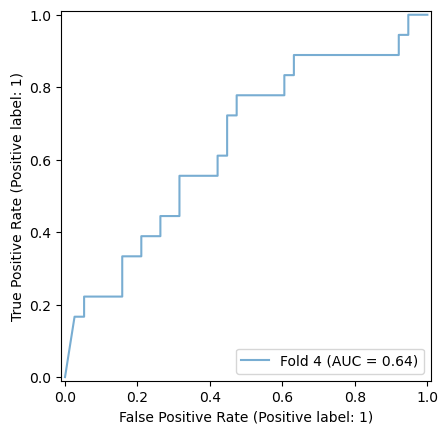

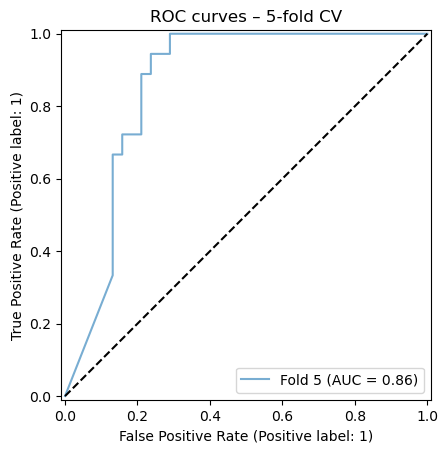

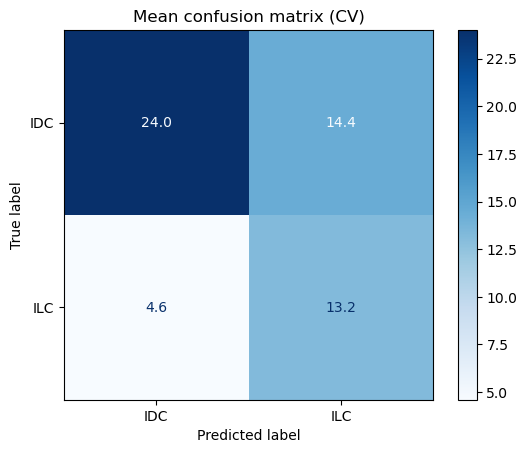

/var/folders/gy/bwg3l6_55tq1pzm0qdpfw_w80000gn/T/ipykernel_30722/1495517296.py:142: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([aucs, baccs], labels=["AUC", "Balanced acc"])


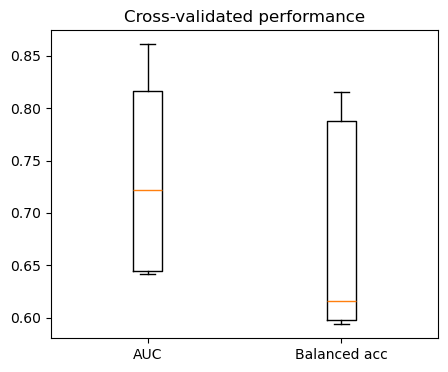


===== FINAL RESULTS =====
AUC : 0.737 ± 0.089
Balanced acc : 0.682 ± 0.098


([0.7222222222222223,
  0.6417797888386123,
  0.8165204678362573,
  0.6440058479532164,
  0.8611111111111112],
 [0.6153846153846154,
  0.5980392156862745,
  0.7880116959064327,
  0.5935672514619883,
  0.8157894736842105])

In [85]:
covars = clinical.loc[y.index, ["TumorPurity", "ProliferationScore"]]

X = Z.loc[y_luma.index]  

X_plus = pd.concat([X, covars], axis=1)

# retirer les patients sans purity
mask = X_plus["TumorPurity"].notna()
X_plus = X_plus.loc[mask]
y_plus = y.loc[mask]



mlp_balanced(X=X_plus, y=y_plus)

mlp_cv_balanced(X=X_plus, y=y_plus)

We further tested whether adding biological covariates known to influence transcriptomic profiles tumor purity and proliferation score could improve the classification of Luminal A IDC versus ILC. The inclusion of these covariates led to only marginal changes in performance, without a consistent improvement in balanced accuracy or cross-validated results. This suggests that differences in tumor cellularity or proliferative activity do not primarily drive the separation between LumA IDC and ILC at the transcriptomic level. We therefore hypothesize that the biological differences between these two histological subtypes within Luminal A tumors are subtle at the RNA level and may instead be better captured by proteomic regulation, cell–cell adhesion pathways, or post-transcriptional mechanisms.